In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit

In [18]:
df = pd.read_csv('geom_ext_rate.csv')
df['MaxTime'] = df['SeasonLength']*10 + 50
df['Dead'] = df['FinalTime'] < df['MaxTime']
df['Rounds'] = np.minimum(df['FinalTime'] // df['SeasonLength'] , 10)
df

,SeasonLength,Trajectory,FinalTime,MaxTime,Dead,Rounds
0,10,0,150.1,150,False,10.0
1,10,1,150.1,150,False,10.0
2,10,2,150.1,150,False,10.0
3,10,3,150.1,150,False,10.0
4,10,4,150.1,150,False,10.0
...,...,...,...,...,...,...
99995,100,9995,116.4,1050,True,1.0
99996,100,9996,127.1,1050,True,1.0
99997,100,9997,120.2,1050,True,1.0
99998,100,9998,119.5,1050,True,1.0


In [19]:
dfext = df.sort_values(['SeasonLength', 'Rounds']).reset_index(drop=True)
dfext = dfext.groupby(['Dead', 'SeasonLength', 'Rounds']).count().reset_index()

dfext['cum'] = dfext.groupby(['Dead', 'SeasonLength'])['Trajectory'].cumsum()
dfext = dfext[dfext['Dead']==True]

dfext['ExtRate'] = dfext['cum'] / 10000
dfext

,Dead,SeasonLength,Rounds,Trajectory,FinalTime,MaxTime,cum,ExtRate
10,True,10,2.0,1,1,1,1,0.0001
11,True,10,4.0,1,1,1,2,0.0002
12,True,10,6.0,2,2,2,4,0.0004
13,True,10,8.0,1,1,1,5,0.0005
14,True,10,9.0,1,1,1,6,0.0006
...,...,...,...,...,...,...,...,...
101,True,100,6.0,515,515,515,7648,0.7648
102,True,100,7.0,449,449,449,8097,0.8097
103,True,100,8.0,343,343,343,8440,0.8440
104,True,100,9.0,267,267,267,8707,0.8707


In [20]:
def geom_model(N, p):
    return 1 - (1 - p)**N

resultados = []

for season, grupo in dfext.groupby('SeasonLength'):
    N_vals = grupo['Rounds'].values
    P_vals = grupo['ExtRate'].values


    sigma_vals = 1 / N_vals
    
    # Ajustar el modelo
    try:
        popt, _ = curve_fit(geom_model, N_vals, P_vals, bounds=(0, 1))
        p_estimado = popt[0]

        popt, _ = curve_fit(geom_model, N_vals, P_vals, bounds=(0, 1),
                            sigma=sigma_vals,
                            absolute_sigma=False  # Pondera con los valores relativos
                           )
        p_estimado_p = popt[0]
    except RuntimeError:
        p_estimado = np.nan  # En caso de que no converja
        p_estimado_p = np.nan

    resultados.append({'SeasonLength': season, 'p_estimado': p_estimado, 'p_estimado_p':p_estimado_p})
    
df_geom = pd.DataFrame(resultados)
df_geom

,SeasonLength,p_estimado,p_estimado_p
0,10,0.000418,0.000545
1,20,0.020845,0.021273
2,30,0.060739,0.059684
3,40,0.090319,0.087026
4,50,0.115182,0.109316
5,60,0.137832,0.129987
6,70,0.157809,0.149345
7,80,0.183702,0.171918
8,90,0.200925,0.189214
9,100,0.223361,0.211238


In [21]:
df_geom.to_csv('estimated_p.csv')

In [ ]:
dfext = pd.merge(dfext, df_geom, on='SeasonLength')
dfext['P'] = 1 - (1-dfext['p_estimado'])**dfext['Rounds']
dfext['P_pesado'] = 1 - (1-dfext['p_estimado_p'])**dfext['Rounds']
dfext

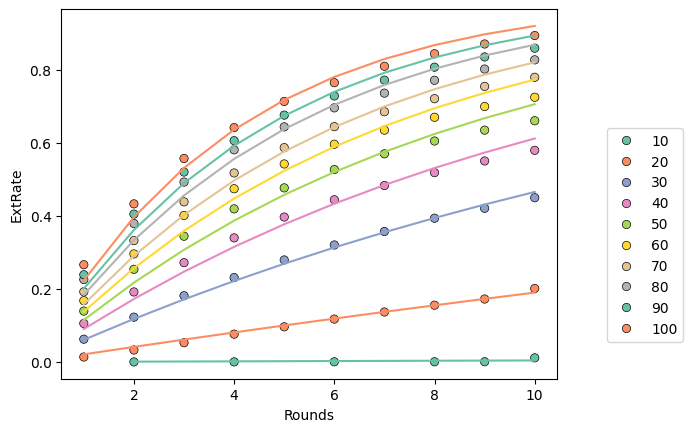

In [23]:
sns.scatterplot(data=dfext, x='Rounds', y='ExtRate', hue='SeasonLength',palette='Set2',ec='black')

sns.lineplot(data=dfext, x='Rounds', y='P', hue='SeasonLength',palette='Set2',legend=False)
#sns.lineplot(data=dfext, x='Rounds', y='P_pesado', hue='SeasonLength',palette='viridis',legend=True)

plt.legend(loc=(1.1,0.1))
plt.show()